### Проверка симптомов COVID-19

#### Импорт необходимых библиотек

In [1]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import klib 
from collections import Counter
%matplotlib inline

## resampling
from imblearn.over_sampling import ADASYN


## Pipeline
from sklearn.pipeline import Pipeline

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  AdaBoostClassifier

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for warning
from warnings import filterwarnings
filterwarnings("ignore")  ## To remove any kind of warning

#### Задача

Построить модель машинного обучения для предсказания диагноза COVID-19 на основании симптомов

**Целевая переменная** - "COVID-19"

#### Загрузка датасета

In [2]:
data = pd.read_csv('/Users/mat/covid_checker/data/Covid Dataset.csv')
pd.pandas.set_option('display.max_columns',None)

In [3]:
data.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running 0se,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,1
1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1
2,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,1
3,1,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1
4,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1


#### Изучение датасета

In [4]:
data.shape

(5434, 21)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Breathing Problem                        5434 non-null   int64
 1   Fever                                    5434 non-null   int64
 2   Dry Cough                                5434 non-null   int64
 3   Sore throat                              5434 non-null   int64
 4   Running 0se                              5434 non-null   int64
 5   Asthma                                   5434 non-null   int64
 6   Chronic Lung Disease                     5434 non-null   int64
 7   Headache                                 5434 non-null   int64
 8   Heart Disease                            5434 non-null   int64
 9   Diabetes                                 5434 non-null   int64
 10  Hyper Tension                            5434 non-null   int64
 11  Fati

In [6]:
data.nunique()

Breathing Problem                          2
Fever                                      2
Dry Cough                                  2
Sore throat                                2
Running 0se                                2
Asthma                                     2
Chronic Lung Disease                       2
Headache                                   2
Heart Disease                              2
Diabetes                                   2
Hyper Tension                              2
Fatigue                                    2
Gastrointestinal                           2
Abroad travel                              2
Contact with COVID Patient                 2
Attended Large Gathering                   2
Visited Public Exposed Places              2
Family working in Public Exposed Places    2
Wearing Masks                              1
Sanitization from Market                   1
COVID-19                                   2
dtype: int64

In [7]:
data.isnull().sum()

Breathing Problem                          0
Fever                                      0
Dry Cough                                  0
Sore throat                                0
Running 0se                                0
Asthma                                     0
Chronic Lung Disease                       0
Headache                                   0
Heart Disease                              0
Diabetes                                   0
Hyper Tension                              0
Fatigue                                    0
Gastrointestinal                           0
Abroad travel                              0
Contact with COVID Patient                 0
Attended Large Gathering                   0
Visited Public Exposed Places              0
Family working in Public Exposed Places    0
Wearing Masks                              0
Sanitization from Market                   0
COVID-19                                   0
dtype: int64

In [8]:
data.duplicated().sum()

4968

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

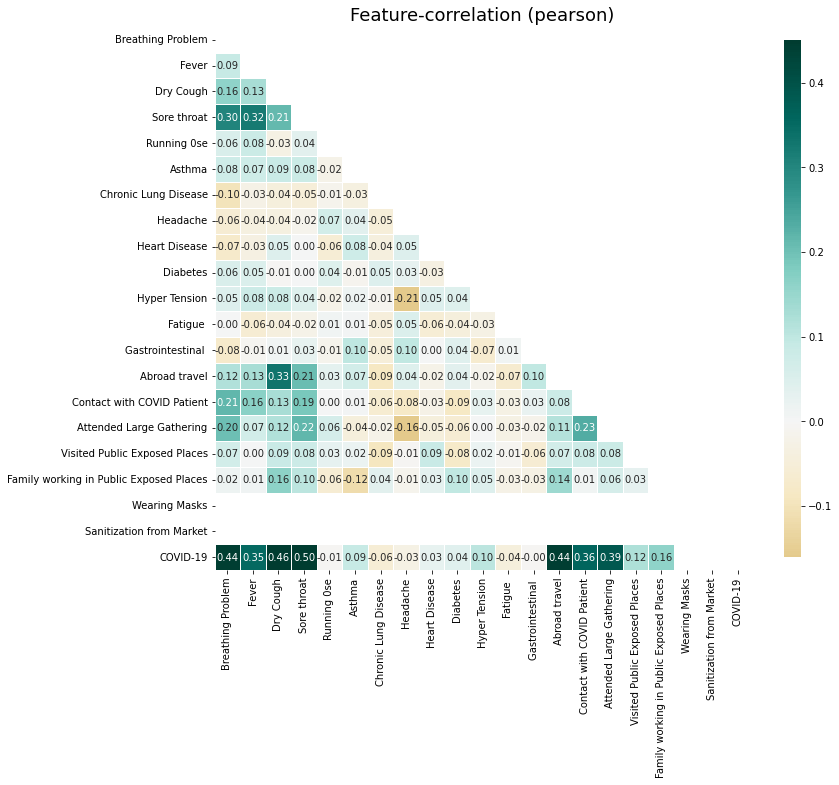

In [9]:
klib.corr_plot(data)

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

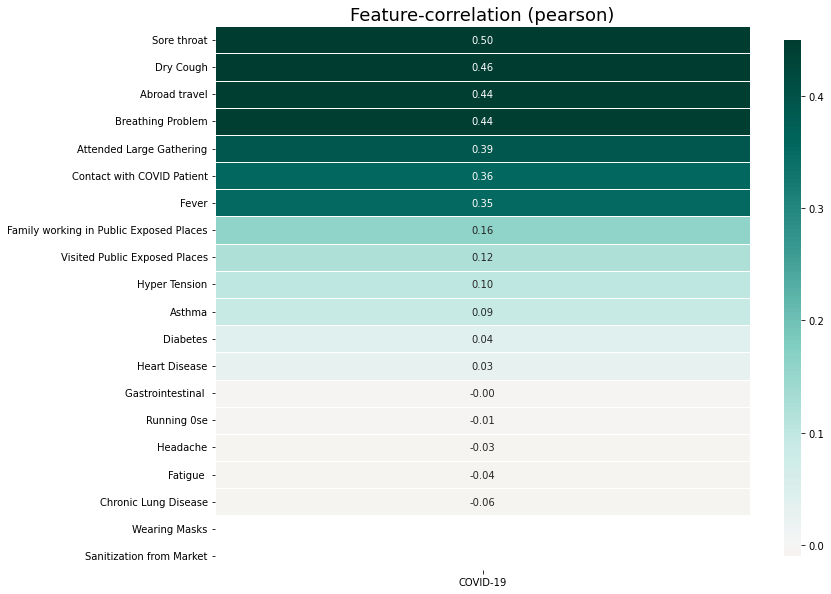

In [10]:
klib.corr_plot(data, target='COVID-19')

1    4383
0    1051
Name: COVID-19, dtype: int64
1    0.806588
0    0.193412
Name: COVID-19, dtype: float64


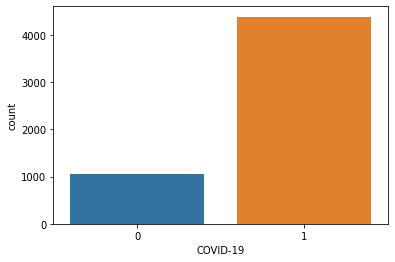

In [11]:
sns.countplot(data['COVID-19'])
print(data['COVID-19'].value_counts())
print(data['COVID-19'].value_counts(normalize=True))

**Выводы**

- датасет содержит набор из 20 признаков, которые влияют на диагноз
- в датасете большое количество дубликатов
- в датасете не пропущенных значений
- все признаки имеют значения "0" или "1", кроме 'Wearing Masks', 'Sanitization from Market'
- есть явная корреляция между целевой переменной и симптомами: "Sore throat", "Dry Cough", "Abroad Travel", "Breathing Problem", "Fever", "Attended Large Gathering", "Contact with COVID Patient"
- дисбаланс целевой переменной (заболевшие 80%, здоровые 20%)
- тип данных в датасете "int64"

**Действия на основании выводов**

- удалить неинформативные признаки 'Wearing Masks', 'Sanitization from Market'
- изменить тип данных на "int8", тем самым уменьшить занимаемой памяти
- сделать аугментацию данных для баланса классов в целевой переменной
- выделим целевую переменную
- удалим дубликаты

In [12]:
data.drop(columns=['Wearing Masks','Sanitization from Market'],
          axis=1,
          inplace=True)

In [13]:
data.duplicated().sum()

4968

In [14]:
data.drop_duplicates(inplace=True)

1    385
0     81
Name: COVID-19, dtype: int64
1    0.82618
0    0.17382
Name: COVID-19, dtype: float64


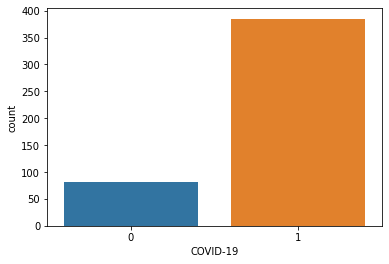

In [15]:
sns.countplot(data['COVID-19'])
print(data['COVID-19'].value_counts())
print(data['COVID-19'].value_counts(normalize=True))

После удаления дубликатов, процентное соотношение классов в целевой переменной не изменилось

In [16]:
data = data.astype('int8')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 0 to 5325
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Breathing Problem                        466 non-null    int8 
 1   Fever                                    466 non-null    int8 
 2   Dry Cough                                466 non-null    int8 
 3   Sore throat                              466 non-null    int8 
 4   Running 0se                              466 non-null    int8 
 5   Asthma                                   466 non-null    int8 
 6   Chronic Lung Disease                     466 non-null    int8 
 7   Headache                                 466 non-null    int8 
 8   Heart Disease                            466 non-null    int8 
 9   Diabetes                                 466 non-null    int8 
 10  Hyper Tension                            466 non-null    int8 
 11  Fatig

После удаления дубликатов и изменения типа данных объем занимаемой памяти уменьшился в 30 раз

In [18]:
y = data['COVID-19']
data.drop(columns='COVID-19',
          axis=1,
          inplace=True)
X = data

<AxesSubplot:xlabel='Breathing Problem', ylabel='Density'>

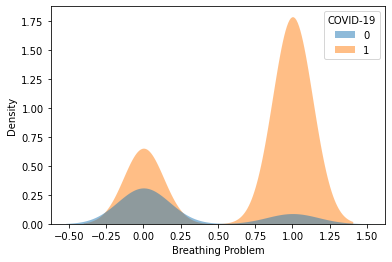

In [19]:
sns.kdeplot(data=X, x='Breathing Problem', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Fever', ylabel='Density'>

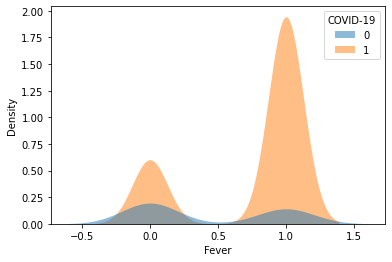

In [20]:
sns.kdeplot(data=X, x='Fever', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Dry Cough', ylabel='Density'>

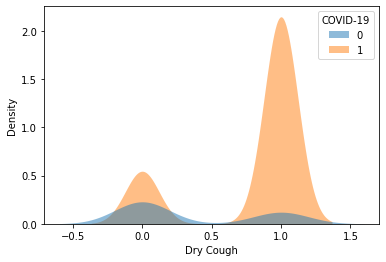

In [21]:
sns.kdeplot(data=X, x='Dry Cough', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Sore throat', ylabel='Density'>

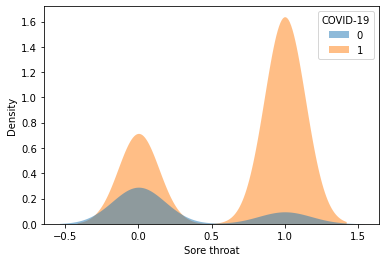

In [22]:
sns.kdeplot(data=X, x='Sore throat', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Running 0se', ylabel='Density'>

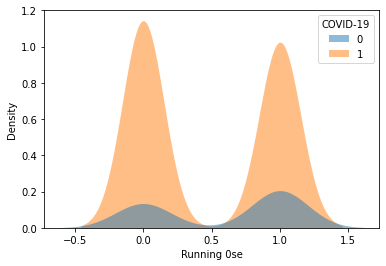

In [23]:
sns.kdeplot(data=X, x='Running 0se', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Asthma', ylabel='Density'>

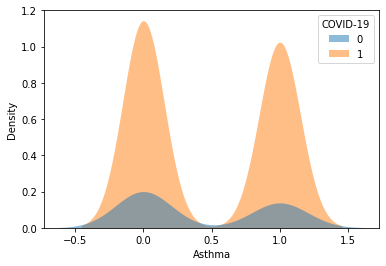

In [24]:
sns.kdeplot(data=X, x='Asthma', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Chronic Lung Disease', ylabel='Density'>

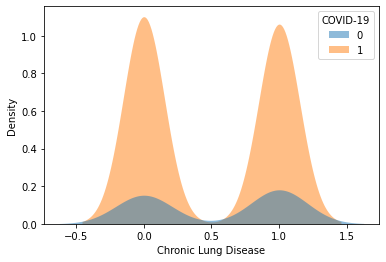

In [25]:
sns.kdeplot(data=X, x='Chronic Lung Disease', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Headache', ylabel='Density'>

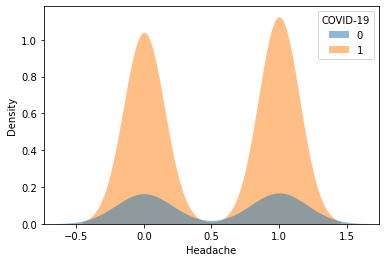

In [26]:
sns.kdeplot(data=X, x='Headache', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Heart Disease', ylabel='Density'>

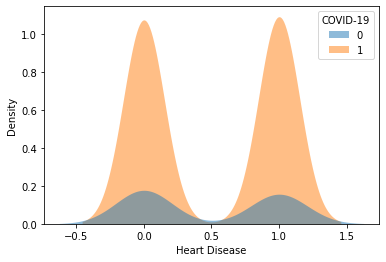

In [27]:
sns.kdeplot(data=X, x='Heart Disease', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Diabetes', ylabel='Density'>

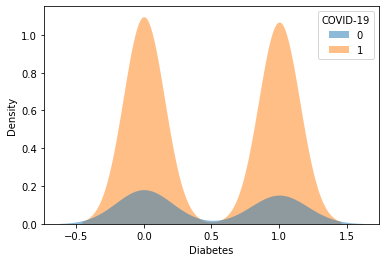

In [28]:
sns.kdeplot(data=X, x='Diabetes', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Hyper Tension', ylabel='Density'>

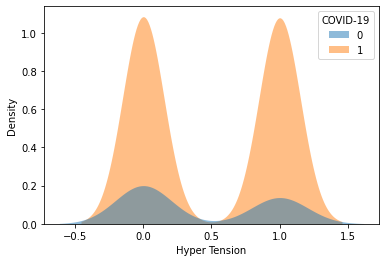

In [29]:
sns.kdeplot(data=X, x='Hyper Tension', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Fatigue ', ylabel='Density'>

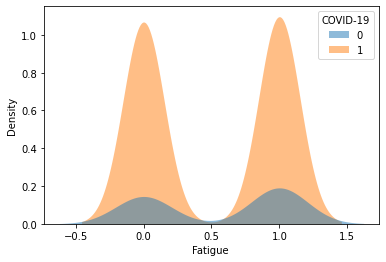

In [30]:
sns.kdeplot(data=X, x='Fatigue ', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Gastrointestinal ', ylabel='Density'>

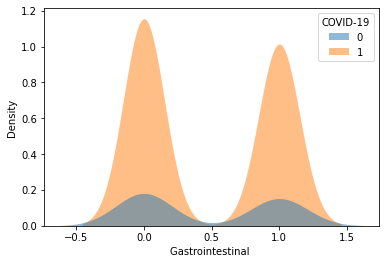

In [31]:
sns.kdeplot(data=X, x='Gastrointestinal ', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Abroad travel', ylabel='Density'>

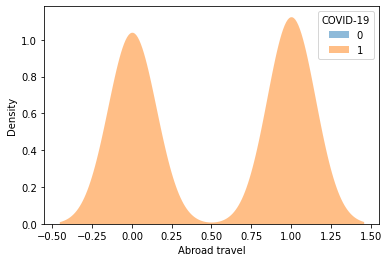

In [32]:
sns.kdeplot(data=X, x='Abroad travel', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Contact with COVID Patient', ylabel='Density'>

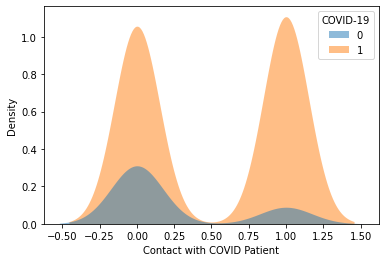

In [33]:
sns.kdeplot(data=X, x='Contact with COVID Patient', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Attended Large Gathering', ylabel='Density'>

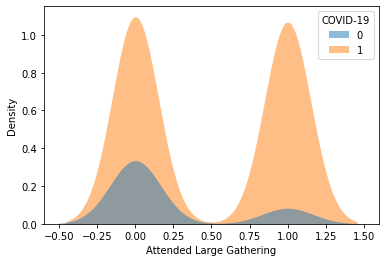

In [34]:
sns.kdeplot(data=X, x='Attended Large Gathering', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Visited Public Exposed Places', ylabel='Density'>

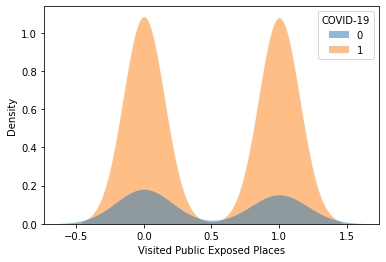

In [35]:
sns.kdeplot(data=X, x='Visited Public Exposed Places', hue=y, fill=True, alpha=.5, linewidth=0)

<AxesSubplot:xlabel='Family working in Public Exposed Places', ylabel='Density'>

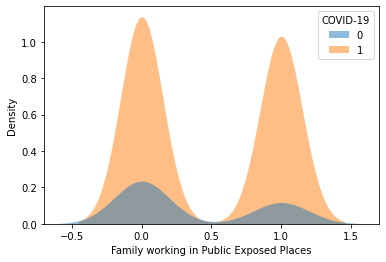

In [36]:
sns.kdeplot(data=X, x='Family working in Public Exposed Places', hue=y, fill=True, alpha=.5, linewidth=0)

Можно сделать предположение, что основные симптомы COVID-19 это 'Breathing Problem', 'Fever', 'Dry Cough' и 'Sore throat'

In [37]:
sampling = ADASYN(sampling_strategy='auto',
                  random_state=23,
                  n_jobs=-1)
print('Размер датасета до аугментации %s' % Counter(y))
X_res, y_res = sampling.fit_resample(X, y)
print('Размер датасета после аугментации %s' % Counter(y_res))

Размер датасета до аугментации Counter({1: 385, 0: 81})
Размер датасета после аугментации Counter({0: 395, 1: 385})


#### Разделение на тестовую и тренировочную выборку

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.4)

In [40]:
from sklearn.linear_model import LogisticRegression

#### Построение модели

KNeighborsClassifier()
Время выполнения: 0.013
Оценка модели: 0.923
              precision    recall  f1-score   support

  COVID-19 -       0.87      1.00      0.93       163
  COVID-19 +       1.00      0.84      0.91       149

    accuracy                           0.92       312
   macro avg       0.94      0.92      0.92       312
weighted avg       0.93      0.92      0.92       312



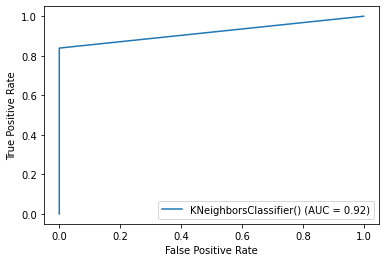

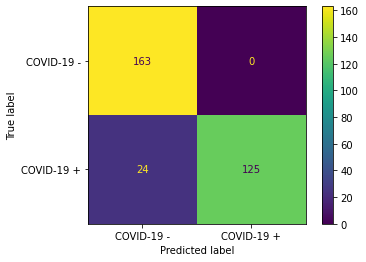

DecisionTreeClassifier()
Время выполнения: 0.003
Оценка модели: 0.946
              precision    recall  f1-score   support

  COVID-19 -       0.93      0.97      0.95       163
  COVID-19 +       0.96      0.92      0.94       149

    accuracy                           0.95       312
   macro avg       0.95      0.94      0.95       312
weighted avg       0.95      0.95      0.95       312



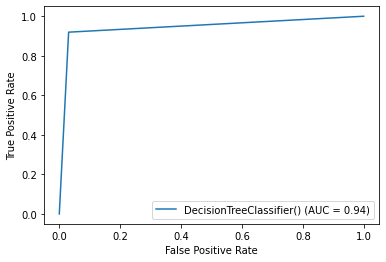

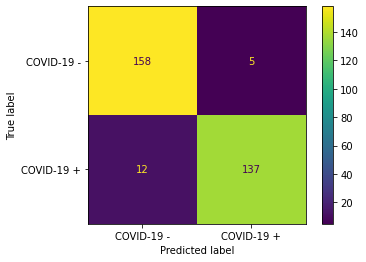

RandomForestClassifier()
Время выполнения: 0.090
Оценка модели: 0.958
              precision    recall  f1-score   support

  COVID-19 -       0.95      0.98      0.96       163
  COVID-19 +       0.97      0.94      0.96       149

    accuracy                           0.96       312
   macro avg       0.96      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312



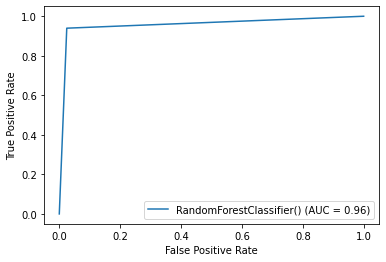

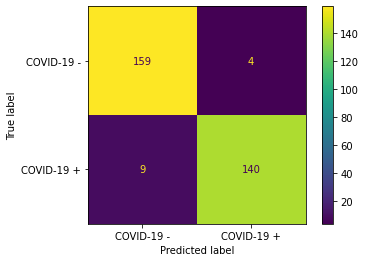

AdaBoostClassifier()
Время выполнения: 0.047
Оценка модели: 0.952
              precision    recall  f1-score   support

  COVID-19 -       0.95      0.96      0.95       163
  COVID-19 +       0.96      0.94      0.95       149

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



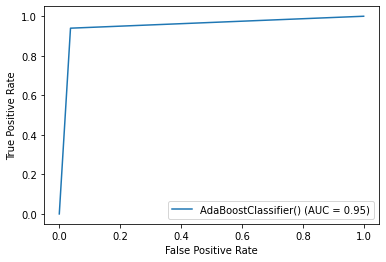

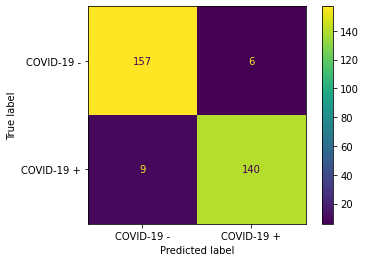

LogisticRegression()
Время выполнения: 0.005
Оценка модели: 0.952
              precision    recall  f1-score   support

  COVID-19 -       0.95      0.96      0.95       163
  COVID-19 +       0.95      0.95      0.95       149

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



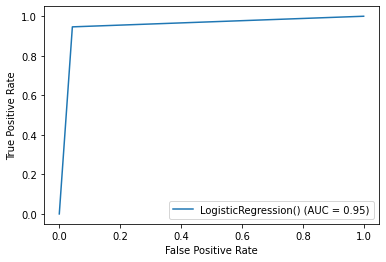

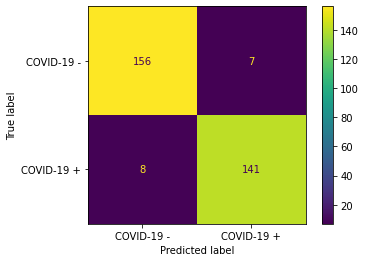

In [41]:
target_names = ['COVID-19 -','COVID-19 +']

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LogisticRegression()
]

for classifier in classifiers:
    start_time = time.time()
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    elapsed_time = time.time() - start_time
    print(classifier)
    print("Время выполнения: %.3f" %elapsed_time)
    print("Оценка модели: %.3f" % pipe.score(X_test, y_test))
    print(classification_report(y_test, y_pred, target_names=target_names))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=classifier)
    display.plot()

    plt.show()
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
    disp.plot()

    plt.show()


Лучший по метрикам и скорости - RandomForestClassifier

### RandomForestClassifier

In [42]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  COVID-19 -       0.95      0.98      0.96       163
  COVID-19 +       0.97      0.95      0.96       149

    accuracy                           0.96       312
   macro avg       0.96      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312



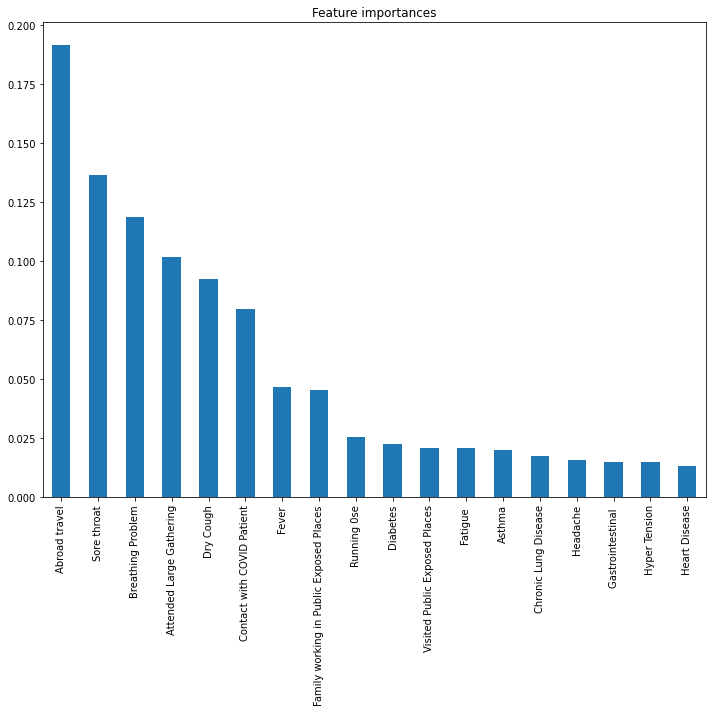

In [43]:
feature_names = X.columns.to_list()
COVID_importances = pd.Series(model.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
COVID_importances.sort_values(ascending=False).plot.bar(ax=ax, figsize=(10,10))
ax.set_title("Feature importances")
fig.tight_layout()

Выберем наиболее значимые признаки и обучим модель на них

In [44]:
features = COVID_importances.nlargest(8).index.tolist()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res[features], y_res, test_size=0.4)

Оценка модели: 0.965
              precision    recall  f1-score   support

  COVID-19 -       0.97      0.96      0.96       144
  COVID-19 +       0.96      0.97      0.97       168

    accuracy                           0.96       312
   macro avg       0.96      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312



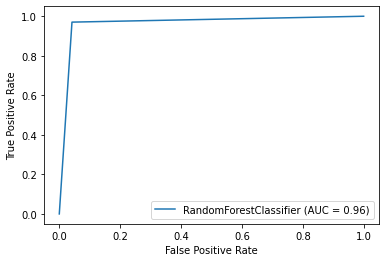

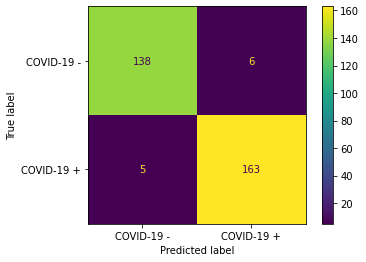

In [46]:
model_RFC = RandomForestClassifier()
model_RFC.fit(X_train, y_train)
y_pred = model_RFC.predict(X_test)
print("Оценка модели: %.3f" % model_RFC.score(X_test, y_test))
print(classification_report(y_test, y_pred, target_names=target_names))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='RandomForestClassifier')
display.plot()

plt.show()
cm = confusion_matrix(y_test, y_pred, labels=model_RFC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()

plt.show()

In [47]:
model_RFC.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [48]:
from sklearn.model_selection import GridSearchCV
n_estimators = [50, 100, 150, 200, 250]
max_features = ['auto','sqrt']
max_depth = [None,2,3,7,11,15]
min_samples_split = [1,2,3,4,22,23,24]
min_samples_leaf = [1,2,3,4,5,6,7]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(model_RFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_score_

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


0.9615384615384616

In [49]:
gs.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 24,
 'n_estimators': 250}

Оценка модели: 0.962
              precision    recall  f1-score   support

  COVID-19 -       0.96      0.96      0.96       144
  COVID-19 +       0.96      0.96      0.96       168

    accuracy                           0.96       312
   macro avg       0.96      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312



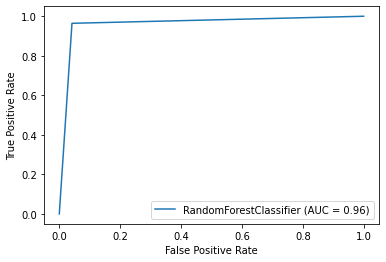

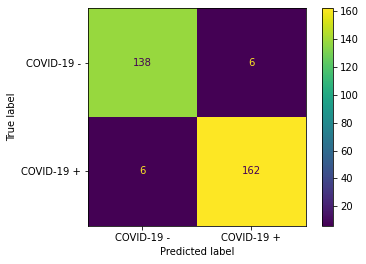

In [50]:
best_model = RandomForestClassifier(bootstrap=True,
                                    max_depth=None,
                                    max_features='auto',
                                    min_samples_leaf=1,
                                    min_samples_split=24,
                                    n_estimators=250)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Оценка модели: %.3f" % best_model.score(X_test, y_test))
print(classification_report(y_test, y_pred, target_names=target_names))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='RandomForestClassifier')
display.plot()

plt.show()
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()

plt.show()

### Сохранение модели

In [51]:
import joblib

with open('model.pkl', 'wb') as f:
    joblib.dump(best_model, f)

In [52]:
features

['Abroad travel',
 'Sore throat',
 'Breathing Problem',
 'Attended Large Gathering',
 'Dry Cough',
 'Contact with COVID Patient',
 'Fever',
 'Family working in Public Exposed Places']

In [53]:
X_train

,Abroad travel,Sore throat,Breathing Problem,Attended Large Gathering,Dry Cough,Contact with COVID Patient,Fever,Family working in Public Exposed Places
573,0,0,0,0,1,0,0,0
342,1,0,0,0,1,1,1,1
356,1,0,1,1,1,1,0,1
718,0,0,0,0,1,0,0,0
688,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
63,1,1,1,1,1,0,1,0
355,1,0,1,1,1,1,0,1
564,0,0,0,0,1,0,0,0
282,1,1,1,0,0,1,1,0
